# California Housing Prices Regression Model Developement

In [1]:
# Common imports
import numpy as np
import os
import sys
import sklearn
import pandas as pd
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(101)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Download the Data

In [2]:
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Exploratory Data Analysis 

### Descriptive Statistics

In [5]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
def percentage_missing(data):
    df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['percent_missing'])
    df.reset_index(inplace = True)
    df.sort_values(by = 'percent_missing', inplace = True, ascending = False)
    df.rename(columns = {'index':'attributes'}, inplace = True)
    return df

In [8]:
percentage_missing(housing)

attributes  percent_missing
4      total_bedrooms         1.002907
0           longitude         0.000000
1            latitude         0.000000
2  housing_median_age         0.000000
3         total_rooms         0.000000
5          population         0.000000
6          households         0.000000
7       median_income         0.000000
8  median_house_value         0.000000
9     ocean_proximity         0.000000

In [9]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
round(housing.describe(),2).transpose()

count       mean        std       min        25%  \
longitude           20640.0    -119.57       2.00   -124.35    -121.80   
latitude            20640.0      35.63       2.14     32.54      33.93   
housing_median_age  20640.0      28.64      12.59      1.00      18.00   
total_rooms         20640.0    2635.76    2181.62      2.00    1447.75   
total_bedrooms      20433.0     537.87     421.39      1.00     296.00   
population          20640.0    1425.48    1132.46      3.00     787.00   
households          20640.0     499.54     382.33      1.00     280.00   
median_income       20640.0       3.87       1.90      0.50       2.56   
median_house_value  20640.0  206855.82  115395.62  14999.00  119600.00   

                          50%        75%        max  
longitude             -118.49    -118.01    -114.31  
latitude                34.26      37.71      41.95  
housing_median_age      29.00      37.00      52.00  
total_rooms           2127.00    3148.00   39320.00  
total_bedrooms         435.00     647.00    6445.00  
population            1166.00    1725.00   35682.00  
households             409.00     605.00    6082.00  
median_income            3.53       4.74      15.00  
median_house_value  179700.00  264725.00  500001.00

*Numeric and categorical columns*

In [11]:
def coltype_csv(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = list(data.select_dtypes(include=numerics).columns)
    non_numerics =['bool','category','object']
    categorical = list(data.select_dtypes(include=non_numerics).columns)
    return (numeric, categorical)

In [12]:
df_num, df_cat = coltype_csv(housing)

In [13]:
df_num

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [14]:
df_cat

['ocean_proximity']

### Histograms

In [15]:
#col_no : number of columns to display in one row
#numeric : name of numeric cols

from scipy.stats import norm

def hist_plots_grid(data, numeric,col_no = 3):
    
    data_fig = pd.melt(data, value_vars= numeric)
    
    fig = sns.FacetGrid(data_fig, col = "variable", 
                        col_wrap = col_no,
                        sharex= False, sharey = False)
    
    fig = fig.map(sns.distplot, "value",
                  hist = True, norm_hist = True,  
                  hist_kws= {'histtype':'step',
                     'color': 'teal','linewidth':1},
                  kde_kws= {'color':'mediumturquoise', 'lw': 2, 'kernel' : 'gau',
                           'shade' : True},
                 fit = norm, fit_kws = {'color':'dimgrey',
                                       'lw':1})
    fig.fig.tight_layout()
    
    return fig

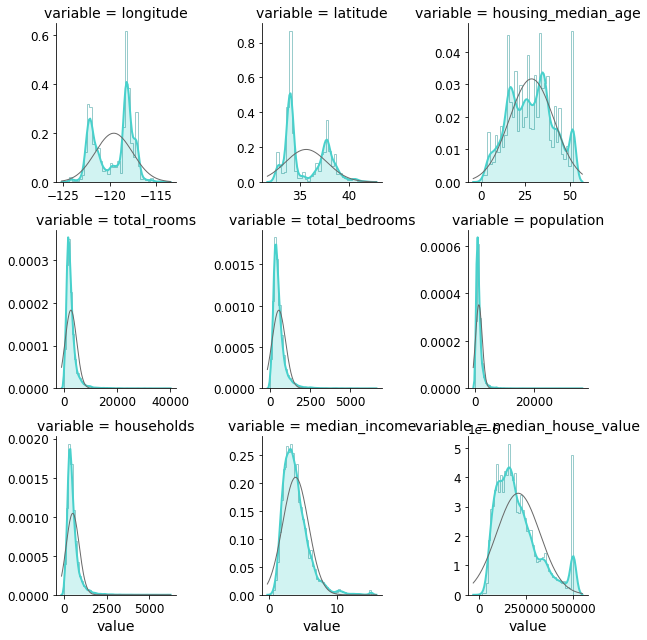

In [16]:
hist_plots_grid(housing,df_num,3)

### Box plots

In [17]:
def boxplots_catvsnum(data, x_cat, y_num, 
                      fig_width = 10, fig_length = 6,
                      title = "Boxplot for comparision"):
    
    fig,(ax) = plt.subplots(1, 1, figsize=(fig_width, fig_length))
    
    fig = sns.boxplot(data=data,
               x=x_cat, y= y_num,   
               ax=ax,
               palette = "colorblind")
    
    ax.axis('tight')
    
    plt.title(title, fontsize=14)
    
    return fig    

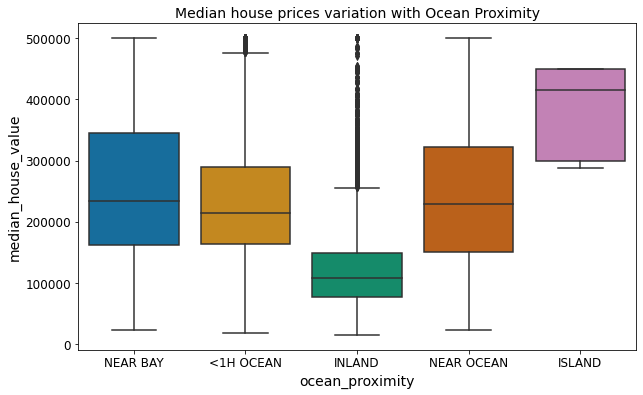

In [18]:
boxplots_catvsnum(housing,'ocean_proximity','median_house_value',
                  title = "Median house prices variation with Ocean Proximity")

### Correlation Plot

In [19]:
def corr_plot(data, fig_width = 10, fig_length = 6, annot = True,
                      title = 'Correlation Heatmap'):
    
    # Compute pairwise correlation of Dataframe's attributes
    data_corr = data.corr()
    
    palette = sns.diverging_palette(20, 220, as_cmap=True)
        
    fig, (ax) = plt.subplots(1, 1, figsize=(fig_width,fig_length))
    
    fig.subplots_adjust(top=1)
    fig.suptitle(title, fontsize = 14)
    
    fig = sns.heatmap(data_corr, 
                 ax=ax,# Axes in which to draw the plot, otherwise use the currently-active Axes.
                 vmin = -1.0,
                 vmax = 1.0,
                 cmap=palette, # Color Map.
                 square=True, # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=annot, 
                 fmt='.1f',# String formatting code to use when adding annotations.
                 annot_kws={"size": 10, 'color' : 'black'},
                 linewidths=.5)
    
    bottom, top = ax.get_ylim()
    
    ax.set_ylim(bottom + 0.5, top - 0.5) 
    
    return fig

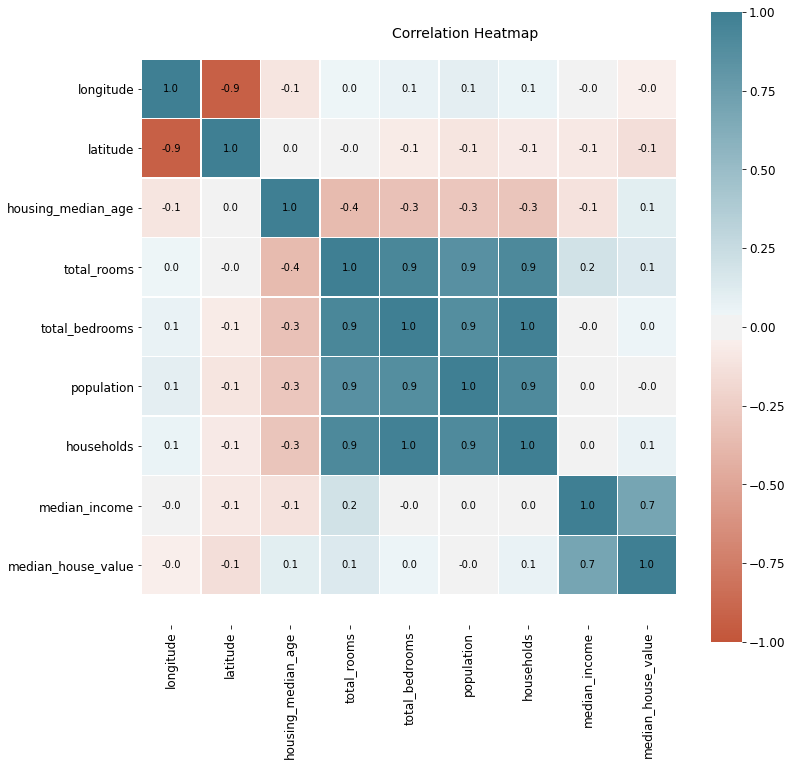

In [20]:
corr_plot(housing, fig_width=12, fig_length=10)

### Pair Plots

In [21]:
def pair_plots(data,col_names,hue_col = None, title = 'Pair Plot'):
    
    fig = sns.PairGrid(data[col_names], hue = hue_col)
    fig = fig.map_upper(sns.scatterplot, s=10)
    fig = fig.map_lower(sns.kdeplot)
    fig = fig.map_diag(sns.distplot, hist= True, kde= False, hist_kws= {'histtype':'step', 'linewidth':1})
    
    plt.suptitle(title,
            y = 1.01,
            fontsize = 28)
    
    return fig

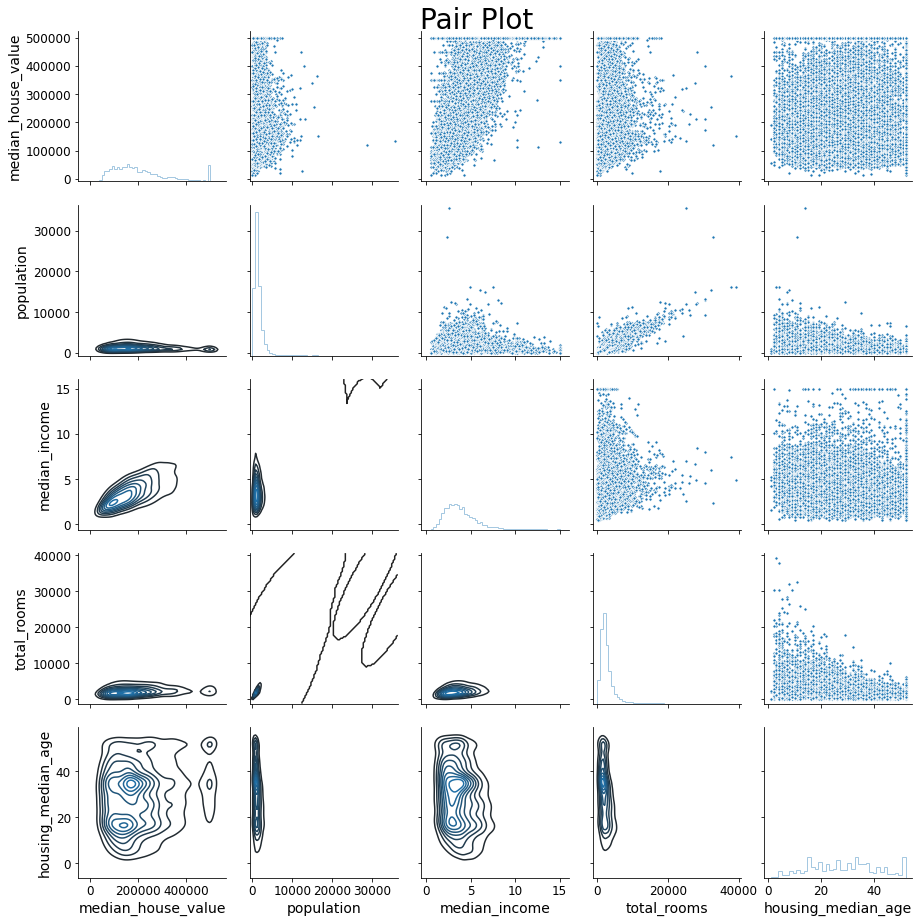

In [22]:
pair_plots(housing,['median_house_value','population',
             'median_income','total_rooms','housing_median_age'])

### Geographical representation of population

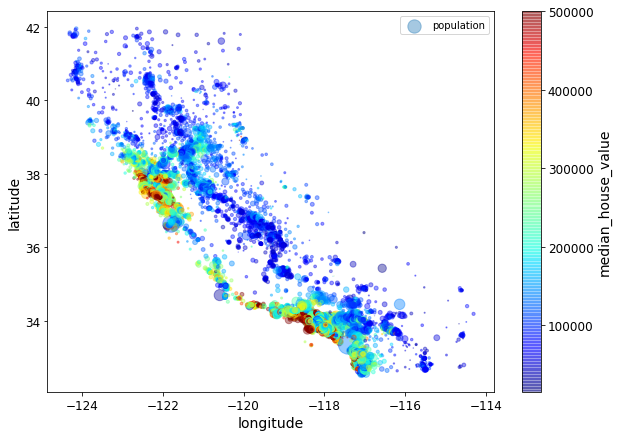

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

## Data Pre-processing 

### Splitting Datasets

In [24]:
# function to be used when stratifying is not necessary 

def split_dataset(data, y, id_col = None, split_ratio =0.8, random_state = 101):
    from sklearn.model_selection import train_test_split
    if (id_col == None):
        drop = y
    else:
        drop = [y,id_col]
    X_train, X_test, y_train, y_test = train_test_split(data.drop(drop,axis = 1), 
                                                    data[y],
                                                    train_size = split_ratio,
                                                    random_state= random_state)
    return (X_train, X_test, y_train, y_test)

In [25]:
X_train, X_test, y_train, y_test = split_dataset(housing,y = 'median_house_value')

In [26]:
len(X_train)

16512

In [27]:
len(X_test)

4128

In [28]:
pd.cut(y_test,bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5]).value_counts()

5    4128
4       0
3       0
2       0
1       0
Name: median_house_value, dtype: int64

In [29]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [30]:
housing.income_cat.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [31]:
# function to be used when stratifying is vital for sampling

def split_datasets_stratify(data, y, id_col = None, 
                            stratify_col = None,split_ratio =0.8, random_state = 101):
    
    from sklearn.model_selection import StratifiedShuffleSplit
    
    if (id_col == None):
        drop = y
    else:
        drop = [y,id_col]
        
    if (stratify_col == None):
        stratify_col = y
        
    split = StratifiedShuffleSplit(n_splits=1, train_size=split_ratio, random_state=random_state)
    for train_index, test_index in split.split(data.drop(drop,axis = 1),data[stratify_col]):
            strat_train_set = data.loc[train_index]
            strat_test_set = data.loc[test_index]
    
    X_train = strat_train_set.drop(y,axis = 1)
    X_test = strat_test_set.drop(y,axis = 1)
    y_train = strat_train_set[y]
    y_test = strat_test_set[y]
    
    return (X_train, X_test, y_train, y_test)

In [32]:
len(X_test)

4128

In [33]:
X_train, X_test, y_train, y_test = split_dataset(housing,y = 'median_house_value')

In [34]:
X_test.income_cat.value_counts()

3    1440
2    1323
4     730
5     470
1     165
Name: income_cat, dtype: int64

### Feature Engineering 

In [35]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [36]:
round(housing.describe(),2).transpose()

count       mean        std       min        25%  \
longitude                 20640.0    -119.57       2.00   -124.35    -121.80   
latitude                  20640.0      35.63       2.14     32.54      33.93   
housing_median_age        20640.0      28.64      12.59      1.00      18.00   
total_rooms               20640.0    2635.76    2181.62      2.00    1447.75   
total_bedrooms            20433.0     537.87     421.39      1.00     296.00   
population                20640.0    1425.48    1132.46      3.00     787.00   
households                20640.0     499.54     382.33      1.00     280.00   
median_income             20640.0       3.87       1.90      0.50       2.56   
median_house_value        20640.0  206855.82  115395.62  14999.00  119600.00   
rooms_per_household       20640.0       5.43       2.47      0.85       4.44   
bedrooms_per_room         20433.0       0.21       0.06      0.10       0.18   
population_per_household  20640.0       3.07      10.39      0.69       2.43   

                                50%        75%        max  
longitude                   -118.49    -118.01    -114.31  
latitude                      34.26      37.71      41.95  
housing_median_age            29.00      37.00      52.00  
total_rooms                 2127.00    3148.00   39320.00  
total_bedrooms               435.00     647.00    6445.00  
population                  1166.00    1725.00   35682.00  
households                   409.00     605.00    6082.00  
median_income                  3.53       4.74      15.00  
median_house_value        179700.00  264725.00  500001.00  
rooms_per_household            5.23       6.05     141.91  
bedrooms_per_room              0.20       0.24       1.00  
population_per_household       2.82       3.28    1243.33

In [37]:
housing.corr()["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [38]:
housing.drop(['bedrooms_per_room','rooms_per_household','population_per_household'], axis = 1, inplace= True)

### Data Cleaning

In [39]:
X_train_clean = X_train.copy()

In [40]:
percentage_missing(X_train_clean)

attributes  percent_missing
4      total_bedrooms         1.011386
0           longitude         0.000000
1            latitude         0.000000
2  housing_median_age         0.000000
3         total_rooms         0.000000
5          population         0.000000
6          households         0.000000
7       median_income         0.000000
8     ocean_proximity         0.000000
9          income_cat         0.000000

In [41]:
X_train_clean[X_train_clean.total_bedrooms.isnull() == True].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
7806     -118.09     33.89                42.0        991.0             NaN   
19122    -122.65     38.25                23.0       4030.0             NaN   
15479    -117.14     33.16                16.0       1660.0             NaN   
4767     -118.37     34.03                37.0       1236.0             NaN   
7547     -118.20     33.92                45.0       1283.0             NaN   

       population  households  median_income ocean_proximity income_cat  
7806        717.0       219.0         4.0926       <1H OCEAN          3  
19122      1852.0       778.0         3.4020       <1H OCEAN          3  
15479       733.0       214.0         5.6874       <1H OCEAN          4  
4767        966.0       292.0         3.0694       <1H OCEAN          3  
7547       1025.0       248.0         3.2798       <1H OCEAN          3

In [42]:
sample_rows = X_train_clean[X_train_clean.total_bedrooms.isnull() == True].head().index

In [43]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train_clean.drop(['ocean_proximity','ocean_proximity'], axis = 1))

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [44]:
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2127.    ,  434.    , 1166.    ,
        409.    ,    3.5313,    3.    ])

In [45]:
X = imputer.transform((X_train_clean.drop(['ocean_proximity'], axis = 1)))

In [46]:
X_train_clean = pd.DataFrame(X, columns=(X_train_clean.drop(['ocean_proximity'], axis = 1).columns),
                          index= X_train_clean.index)

In [47]:
sample_rows

Int64Index([7806, 19122, 15479, 4767, 7547], dtype='int64')

In [48]:
X_train_clean.loc[sample_rows.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
7806     -118.09     33.89                42.0        991.0           434.0   
19122    -122.65     38.25                23.0       4030.0           434.0   
15479    -117.14     33.16                16.0       1660.0           434.0   
4767     -118.37     34.03                37.0       1236.0           434.0   
7547     -118.20     33.92                45.0       1283.0           434.0   

       population  households  median_income  income_cat  
7806        717.0       219.0         4.0926         3.0  
19122      1852.0       778.0         3.4020         3.0  
15479       733.0       214.0         5.6874         4.0  
4767        966.0       292.0         3.0694         3.0  
7547       1025.0       248.0         3.2798         3.0

### Encoding text attributes

In [49]:
X_train_cat = X_train[df_cat]

In [50]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_train_cat_1hot = cat_encoder.fit_transform(X_train_cat)
X_train_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [51]:
X_train_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [52]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Transformation Pipelines

Creating a custom transformer to add extra attributes

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class combined_attributes_adder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [54]:
attr_adder = combined_attributes_adder(add_bedrooms_per_room=False)

In [55]:
housing_extra_attribs = attr_adder.transform(housing.values)

In [56]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms population  \
0   -122.23    37.88                 41         880            129        322   
1   -122.22    37.86                 21        7099           1106       2401   
2   -122.24    37.85                 52        1467            190        496   
3   -122.25    37.85                 52        1274            235        558   
4   -122.25    37.85                 52        1627            280        565   

  households median_income median_house_value ocean_proximity income_cat  \
0        126        8.3252             452600        NEAR BAY          5   
1       1138        8.3014             358500        NEAR BAY          5   
2        177        7.2574             352100        NEAR BAY          5   
3        219        5.6431             341300        NEAR BAY          4   
4        259        3.8462             342200        NEAR BAY          3   

  rooms_per_household population_per_household  
0             6.98413                  2.55556  
1             6.23814                  2.10984  
2             8.28814                  2.80226  
3             5.81735                  2.54795  
4             6.28185                  2.18147

In [57]:
X_train.drop(['income_cat'],axis =1, inplace = True)

#### Numerical Pipeline

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', combined_attributes_adder()),
        ('std_scaler', StandardScaler()),
    ])

X_train_num_tr = num_pipeline.fit_transform(X_train.drop(['ocean_proximity'],axis = 1))

#### Complete Pipeline

In [59]:
from sklearn.compose import ColumnTransformer

num_attribs = list(X_train.drop(['ocean_proximity'],axis = 1).columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_pre = full_pipeline.fit_transform(X_train)

In [60]:
X_train_pre.shape

(16512, 16)

## Model Development

### Linear Regression as base model

In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_pre, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Cross Validation

In [62]:
#cross validation RMSE scores for training data

def cv_scores_calc(model,X_train,y_train,nfolds = 5):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = nfolds)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

def display_scores(scores):
    print("RMSEs for nflods:", scores)
    print("The mean cross-validation score and the 95% confidence interval: ")
    print("Cross Validation RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [63]:
display_scores(cv_scores_calc(lin_reg,X_train_pre,y_train,nfolds = 10))

RMSEs for nflods: [68838.41638434 68164.59794036 67584.71622785 64262.08218775
 71370.66306995 64266.20149016 68132.89439845 70157.93757605
 68269.93747863 66975.423917  ]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 67802.29 (+/- 4270.05)


#### Out Sample Error

In [64]:
def out_sample_rmse(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import mean_squared_error
    
    mse = mean_squared_error(y_test,y_pred)
    return (np.sqrt(mse))

In [65]:
X_test_pre = full_pipeline.fit_transform(X_test)

In [66]:
out_sample_rmse(lin_reg,X_test_pre,y_test)

71419.31367567799

### Light GBM

[LightGBM](https://lightgbm.readthedocs.io/en/latest/) is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

In [67]:
import lightgbm as lgb

#### Elementary Model

In [68]:
%%time

lgb_reg = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, 
                            learning_rate=0.1, n_estimators=500, subsample_for_bin=200000, 
                            objective='regression', min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, 
                            subsample=1.0,colsample_bytree=1.0, random_state=101, n_jobs=8, silent=True)
lgb_reg.fit(X_train_pre,y_train)

Wall time: 632 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=8, num_leaves=31, objective='regression',
              random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

##### Cross Validation Errors

In [69]:
display_scores(cv_scores_calc(lgb_reg,X_train_pre,y_train,nfolds = 10))

RMSEs for nflods: [46264.31417715 42651.8019169  43219.5386198  42496.32172885
 45309.79449826 43094.69235744 43267.98743783 45830.74056327
 43669.59553982 42457.5353901 ]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 43826.23 (+/- 2714.70)


#### Random Search Hyper parameter Tuning

In [70]:
def random_grid_lgb_reg():
    boosting_type = ['gbdt']
    n_estimators = [int(x) for x in np.linspace(start = 500, stop = 3000, num = 6)]
    learning_rate = [float(x) for x in np.linspace(start = 0.01, stop = 1, num = 5,dtype = 'float')]
    max_depth = [1,5,10,25,50,100]
    num_leaves = [2,4,8,16,32,64,128,256]
    subsample = [0.3,0.5,0.8,1.0]
    colsample_bytree = [0.5,0.8,1.0]
    
    random_grid = {'boosting_type' : boosting_type, 'n_estimators' : n_estimators,
                   'learning_rate': learning_rate, 'max_depth': max_depth,
                   'num_leaves' : num_leaves, 'subsample' : subsample ,
                   'colsample_bytree': colsample_bytree}
    return(random_grid)

In [71]:
random_grid_lgb_reg()

{'boosting_type': ['gbdt'],
 'n_estimators': [500, 1000, 1500, 2000, 2500, 3000],
 'learning_rate': [0.01, 0.2575, 0.505, 0.7525, 1.0],
 'max_depth': [1, 5, 10, 25, 50, 100],
 'num_leaves': [2, 4, 8, 16, 32, 64, 128, 256],
 'subsample': [0.3, 0.5, 0.8, 1.0],
 'colsample_bytree': [0.5, 0.8, 1.0]}

In [72]:
%%time

from sklearn.model_selection import RandomizedSearchCV

model = lgb.LGBMRegressor()

lgb_reg_rand = RandomizedSearchCV(estimator = model, param_distributions = random_grid_lgb_reg(), 
                       n_iter = 100, cv = 5, random_state=101, n_jobs= 10, verbose = 2)

lgb_reg_rand.fit(X_train_pre,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   46.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  8.5min
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed: 11.9min finished


Wall time: 12min


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.5, 0.8

In [73]:
lgb_reg_rand.best_params_

{'subsample': 0.3,
 'num_leaves': 128,
 'n_estimators': 1000,
 'max_depth': 25,
 'learning_rate': 0.01,
 'colsample_bytree': 0.5,
 'boosting_type': 'gbdt'}

In [74]:
import joblib
#saving model
joblib.dump(lgb_reg_rand.best_estimator_,'california_housing_prices_lgb_rand_search_v1.pkl', compress = 1)

['california_housing_prices_lgb_rand_search_v1.pkl']

##### Cross Validation Errors

In [75]:
%%time
display_scores(cv_scores_calc(lgb_reg_rand.best_estimator_,X_train_pre,y_train))

RMSEs for nflods: [44092.83247451 42228.09772736 43651.32441486 44185.17718891
 42407.01229455]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 43312.89 (+/- 1668.80)
Wall time: 17.8 s


##### Out Sample Error

In [76]:
out_sample_rmse(lgb_reg_rand.best_estimator_,X_test_pre,y_test)

49749.654378053114

#### Grid Search with Cross Validation

In [77]:
%%time

from sklearn.model_selection import GridSearchCV

model = lgb.LGBMRegressor()

param_grid = {'boosting_type' : ['gbdt'], 'n_estimators' : [500,1000,1500],
                   'learning_rate': [0.01,0.005,0.1], 'max_depth': [20,22,25],
                   'num_leaves' : [64,128,256], 'subsample' : [0.3,0.5,1.0] ,
                   'colsample_bytree': [0.4,0.5,0.3,1.0]}

lgb_grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 5, n_jobs = 10, verbose = 2)

lgb_grid_search.fit(X_train_pre, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 10.8min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed: 16.7min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed: 24.6min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed: 37.8min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 48.9min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed: 60.1min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 77.0min
[Parallel(n_jobs=10)]: Done 4860 out of 4860 | elapsed: 102.2min finished


Wall time: 1h 42min 18s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=10,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.4, 0.5, 0.3, 1.0],
                         'learning_rate': [0.01, 0.005, 0.1],
 

In [78]:
lgb_grid_search.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 20,
 'n_estimators': 1500,
 'num_leaves': 128,
 'subsample': 0.3}

In [79]:
import joblib
#saving model
joblib.dump(lgb_grid_search.best_estimator_,'california_housing_prices_lgb_grid_search_v1.pkl', compress = 1)

['california_housing_prices_lgb_grid_search_v1.pkl']

##### Cross Validation Errors

In [80]:
%%time

display_scores(cv_scores_calc(lgb_grid_search.best_estimator_,X_train_pre,y_train))

RMSEs for nflods: [43815.00963071 41974.97211556 43626.28432801 43956.42631121
 42279.82183353]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 43130.50 (+/- 1662.63)
Wall time: 24.8 s


##### Out Sample Error

In [81]:
out_sample_rmse(lgb_grid_search.best_estimator_,X_test_pre,y_test)

49766.595786178

### XGBoost

[XGBoost](https://github.com/dmlc/xgboost) is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

In [82]:
import xgboost as xgb

#### Elementary Model 

In [83]:
%%time

xgb_reg = xgb.XGBRegressor(n_estimator = 1000, max_depth = 10, learning_rate = 0.01,
                          objective='reg:squarederror', random_state = 101)

xgb_reg.fit(X_train_pre,y_train)

Wall time: 1.51 s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimator=1000, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=101, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

##### Cross Validation Errors

In [84]:
display_scores(cv_scores_calc(xgb_reg,X_train_pre,y_train,nfolds = 10))

RMSEs for nflods: [104455.27125332  99155.16577499 101782.76998237  99656.00126644
 104084.73681044  99542.09834341 101310.1186507  101782.70090841
  99807.49657838  98748.07215681]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 101032.44 (+/- 3825.91)


#### Random Search Hyper parameter Tuning

In [85]:
def random_grid_xgb_reg():
    n_estimators = [int(x) for x in np.linspace(start = 500, stop = 3000, num = 6)]
    learning_rate = [float(x) for x in np.linspace(start = 0.01, stop = 1, num = 5,dtype = 'float')]
    max_depth = [1,5,10,25,50,100]
    subsample = [0.3,0.5,0.8,1.0]
    colsample_bytree = [0.5,0.8,1.0]
    
    random_grid = {'n_estimators' : n_estimators,'learning_rate': learning_rate, 
                   'max_depth': max_depth,'subsample' : subsample ,
                   'colsample_bytree': colsample_bytree}
    return(random_grid)

In [86]:
random_grid_xgb_reg()

{'n_estimators': [500, 1000, 1500, 2000, 2500, 3000],
 'learning_rate': [0.01, 0.2575, 0.505, 0.7525, 1.0],
 'max_depth': [1, 5, 10, 25, 50, 100],
 'subsample': [0.3, 0.5, 0.8, 1.0],
 'colsample_bytree': [0.5, 0.8, 1.0]}

In [87]:
%%time

from sklearn.model_selection import RandomizedSearchCV

model = xgb.XGBRegressor()

xgb_reg_rand = RandomizedSearchCV(estimator = model, param_distributions = random_grid_xgb_reg(), 
                       n_iter = 100, cv = 5, random_state=101, n_jobs= 10, verbose = 2)

xgb_reg_rand.fit(X_train_pre,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 37.9min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 79.7min
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed: 125.8min finished


Wall time: 2h 6min 27s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          verbosity=None),
                   iid='deprecated', n_iter=100, n_jobs=10,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 

In [88]:
xgb_reg_rand.best_params_

{'subsample': 0.8,
 'n_estimators': 3000,
 'max_depth': 10,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [89]:
import joblib
#saving model
joblib.dump(xgb_reg_rand.best_estimator_,'california_housing_prices_xgb_rand_search_v1.pkl', compress = 1)

['california_housing_prices_xgb_rand_search_v1.pkl']

##### Cross Validation Errors

In [90]:
%%time
display_scores(cv_scores_calc(xgb_reg_rand.best_estimator_,X_train_pre,y_train))

RMSEs for nflods: [43837.62932985 42592.69393011 44246.27401663 44803.21007686
 42447.60409157]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 43585.48 (+/- 1846.83)
Wall time: 2min 30s


##### Out Sample Error

In [91]:
out_sample_rmse(xgb_reg_rand.best_estimator_,X_test_pre,y_test)

50960.31883761639

#### Grid Search with Cross Validation

In [94]:
%%time

from sklearn.model_selection import GridSearchCV

model = xgb.XGBRegressor()

param_grid = {'n_estimators' : [2500,3000,350],'learning_rate': [0.01,0.05,0.1], 
                   'max_depth': [8,10,15],'subsample' : [0.8,0.9,1.0] ,
                   'colsample_bytree': [0.8,0.9,1.0]}

xgb_grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 5, n_jobs = 10, verbose = 2)

xgb_grid_search.fit(X_train_pre, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 32.3min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 74.0min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 138.0min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed: 232.6min
[Parallel(n_jobs=10)]: Done 1215 out of 1215 | elapsed: 291.4min finished


Wall time: 4h 51min 55s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=10,
             param_grid=

In [95]:
xgb_grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 3000,
 'subsample': 0.8}

In [96]:
import joblib
#saving model
joblib.dump(xgb_grid_search.best_estimator_,'california_housing_prices_xgb_grid_search_v1.pkl', compress = 1)

['california_housing_prices_xgb_grid_search_v1.pkl']

##### Cross Validation Errors

In [97]:
%%time

display_scores(cv_scores_calc(xgb_grid_search.best_estimator_,X_train_pre,y_train))

RMSEs for nflods: [43547.88178456 42292.88040739 44010.02707467 44560.5559001
 42295.15994457]
The mean cross-validation score and the 95% confidence interval: 
Cross Validation RMSE: 43341.30 (+/- 1826.48)
Wall time: 2min


##### Out Sample Error

In [99]:
out_sample_rmse(xgb_grid_search.best_estimator_,X_test_pre,y_test)

50591.8364326458